In [1]:
# Checklist:
# AWS emr-5.29.0
# MASTER r5d.8xlarge 1x, no EBS
# CORE r5d.8xlarge 4x, no EBS
# Custom bootstrap action: s3://ydatazian/bootstrap.sh
# Allow ssh in master node security group

In [2]:
import tqdm.notebook as tqdm
import numpy as np
import scipy
import sklearn
import matplotlib.pyplot as plt

# SparkSession

https://spark.apache.org/docs/2.4.4/api/python/pyspark.html

https://spark.apache.org/docs/2.4.4/api/python/pyspark.sql.html

In [3]:
import findspark
findspark.init()

import spark_utils
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
sc = SparkContext("yarn", "My App", conf=spark_utils.get_spark_conf())
se = SparkSession(sc)
spark_utils.print_ui_links()

NameNode: http://ec2-3-15-144-30.us-east-2.compute.amazonaws.com:50070
YARN: http://ec2-3-15-144-30.us-east-2.compute.amazonaws.com:8088
Spark UI: http://ec2-3-15-144-30.us-east-2.compute.amazonaws.com:20888/proxy/application_1589872398847_0001


# Ephemeral local HDFS

In [4]:
! hdfs dfs -df -h

Filesystem                                                Size     Used  Available  Use%
hdfs://ip-172-31-13-168.us-east-2.compute.internal:8020  8.7 T  444.5 M      8.7 T    0%


In [5]:
! hdfs dfs -ls /

Found 3 items
drwxrwxrwt   - hdfs hadoop          0 2020-05-19 07:13 /tmp
drwxr-xr-x   - hdfs hadoop          0 2020-05-19 07:13 /user
drwxr-xr-x   - hdfs hadoop          0 2020-05-19 07:13 /var


# Persistent S3

https://www.kaggle.com/c/outbrain-click-prediction/data

In [6]:
! aws s3 ls s3://ydatazian

2020-05-09 13:43:02       1732 bootstrap.sh
2020-05-07 21:18:30  176843889 clicks_test.parquet
2020-05-07 21:18:30  495815517 clicks_train.parquet
2020-05-07 21:18:30   34267065 documents_categories.parquet
2020-05-07 21:18:30  206455957 documents_entities.parquet
2020-05-07 21:18:30   23859965 documents_meta.parquet
2020-05-07 21:18:31  187410196 documents_topics.parquet
2020-05-07 21:18:32  734643471 events.parquet
2020-05-07 21:18:35 50764611872 page_views.parquet
2020-05-07 21:18:35  248421413 page_views_sample.parquet
2020-05-07 21:18:36    5116927 promoted_content.parquet
2020-05-07 21:18:36  273136709 sample_submission.csv


# Read directly from S3

In [7]:
df = se.read.parquet("s3://ydatazian/page_views.parquet")
df.show(5)

+--------------+-----------+---------+--------+------------+--------------+
|          uuid|document_id|timestamp|platform|geo_location|traffic_source|
+--------------+-----------+---------+--------+------------+--------------+
|1fd5f051fba643|        120| 31905835|       1|          RS|             2|
|8557aa9004be3b|        120| 32053104|       1|       VN>44|             2|
|c351b277a358f0|        120| 54013023|       1|       KR>12|             1|
|8205775c5387f9|        120| 44196592|       1|       IN>16|             2|
|9cb0ccd8458371|        120| 65817371|       1|   US>CA>807|             2|
+--------------+-----------+---------+--------+------------+--------------+
only showing top 5 rows



# Register all tables for sql queries

In [8]:
from IPython.display import display
tables = ["clicks_test", "clicks_train", 
          "documents_categories", "documents_entities", "documents_meta", "documents_topics", 
          "events", "page_views", "page_views_sample", "promoted_content"]
for name in tqdm.tqdm(tables):
    df = se.read.parquet("s3://ydatazian/{}.parquet".format(name))
    df.registerTempTable(name)
    print(name)
    display(df.limit(3).toPandas())

clicks_test


,display_id,ad_id
0,16874594,66758
1,16874594,150083
2,16874594,162754


clicks_train


,display_id,ad_id,clicked
0,1,42337,0
1,1,139684,0
2,1,144739,1


documents_categories


,document_id,category_id,confidence_level
0,1595802,1611,0.92
1,1595802,1610,0.07
2,1524246,1807,0.92


documents_entities


,document_id,entity_id,confidence_level
0,1524246,f9eec25663db4cd83183f5c805186f16,0.672865314504701
1,1524246,55ebcfbdaff1d6f60b3907151f38527a,0.399113728441297
2,1524246,839907a972930b17b125eb0247898412,0.392095749652966


documents_meta


,document_id,source_id,publisher_id,publish_time
0,1595802,1,603,2016-06-05 00:00:00
1,1524246,1,603,2016-05-26 11:00:00
2,1617787,1,603,2016-05-27 00:00:00


documents_topics


,document_id,topic_id,confidence_level
0,1595802,140,0.0731131601068925
1,1595802,16,0.0594164867373976
2,1595802,143,0.0454207537554526


events


,display_id,uuid,document_id,timestamp,platform,geo_location
0,1,cb8c55702adb93,379743,61,3,US>SC>519
1,2,79a85fa78311b9,1794259,81,2,US>CA>807
2,3,822932ce3d8757,1179111,182,2,US>MI>505


page_views


,uuid,document_id,timestamp,platform,geo_location,traffic_source
0,1fd5f051fba643,120,31905835,1,RS,2
1,8557aa9004be3b,120,32053104,1,VN>44,2
2,c351b277a358f0,120,54013023,1,KR>12,1


page_views_sample


,uuid,document_id,timestamp,platform,geo_location,traffic_source
0,1fd5f051fba643,120,31905835,1,RS,2
1,8557aa9004be3b,120,32053104,1,VN>44,2
2,c351b277a358f0,120,54013023,1,KR>12,1


promoted_content


,ad_id,document_id,campaign_id,advertiser_id
0,1,6614,1,7
1,2,471467,2,7
2,3,7692,3,7


# Simple SQL query

In [9]:
%%time
df = se.sql(
"""
select 
    uuid, 
    count(1) as cnt
from page_views
group by uuid
""")
df.write.parquet("/count_per_user.parquet", mode='overwrite')

CPU times: user 3.23 ms, sys: 2.32 ms, total: 5.55 ms
Wall time: 42.5 s


In [10]:
%%time
se.read.parquet("/count_per_user.parquet").show(5)

+--------------+---+
|          uuid|cnt|
+--------------+---+
|9c54fedd0966bd| 41|
|8c4d9610f37c39|  6|
|4af36579238d08|  1|
|ca69b3a9d4bc5d|  4|
|4912410df5ea01| 13|
+--------------+---+
only showing top 5 rows

CPU times: user 859 µs, sys: 1.4 ms, total: 2.25 ms
Wall time: 541 ms


In [11]:
! hdfs dfs -ls /

Found 4 items
drwxr-xr-x   - hadoop hadoop          0 2020-05-19 07:20 /count_per_user.parquet
drwxrwxrwt   - hdfs   hadoop          0 2020-05-19 07:13 /tmp
drwxr-xr-x   - hdfs   hadoop          0 2020-05-19 07:13 /user
drwxr-xr-x   - hdfs   hadoop          0 2020-05-19 07:13 /var


# The same in Python (10x slower)

In [12]:
df = se.table("page_views")
print(df)

DataFrame[uuid: string, document_id: string, timestamp: string, platform: string, geo_location: string, traffic_source: string]


In [13]:
rdd = df.rdd
print(rdd)
print(rdd.take(1))  # sent to driver (our Jupyter kernel)
print(rdd.take(1)[0].uuid)  # Python object

MapPartitionsRDD[81] at javaToPython at NativeMethodAccessorImpl.java:0
[Row(uuid='1fd5f051fba643', document_id='120', timestamp='31905835', platform='1', geo_location='RS', traffic_source='2')]
1fd5f051fba643


In [14]:
%%time
! hdfs dfs -rm -r /count_per_user.pickle
se.table("page_views").rdd\
    .map(lambda x: (x.uuid, 1))\
    .reduceByKey(lambda x, y: x + y)\
    .saveAsPickleFile("/count_per_user.pickle")

rm: `/count_per_user.pickle': No such file or directory
CPU times: user 64.4 ms, sys: 30.6 ms, total: 95 ms
Wall time: 4min 32s


In [15]:
%%time
sc.pickleFile("/count_per_user.pickle").take(5)

CPU times: user 2.99 ms, sys: 1.48 ms, total: 4.47 ms
Wall time: 256 ms


[('b55c4bde05218f', 4),
 ('8f3c508c414ef5', 35),
 ('2029fa127eb2d6', 3),
 ('a680df05e64224', 4),
 ('85fe33cd504ae3', 2)]

In [16]:
# and we can convert it back to Spark DataFrame
from pyspark.sql import Row
rdd_of_rows = sc.pickleFile("/count_per_user.pickle")\
    .map(lambda x: Row(uuid=x[0], cnt=x[1]))
df = se.createDataFrame(rdd_of_rows)
df.write.parquet("/count_per_user_converted.parquet", mode='overwrite')

In [17]:
df = se.read.parquet("/count_per_user_converted.parquet")
df.printSchema()
df.show(5)

root
 |-- cnt: long (nullable = true)
 |-- uuid: string (nullable = true)

+---+--------------+
|cnt|          uuid|
+---+--------------+
| 19|47819dd1cad63a|
|  2|656997b312c421|
|  1|b6abf5e9e3b36a|
| 10|e538f51705a119|
|  5|481de0c20c49ed|
+---+--------------+
only showing top 5 rows



In [42]:
! hdfs dfs -du -s -h "/*"

18.5 M  /count_per_document.parquet
123.0 K  /count_per_topic.parquet
10.4 G  /count_per_user.parquet
19.1 G  /count_per_user.pickle
10.4 G  /count_per_user_converted.parquet
0  /imps_clks_per_user.parquet
31.4 G  /platforms_per_user.pickle
31.4 G  /platforms_per_user2.pickle
0  /tmp
220.5 M  /user
447  /users_with_mult_traffic_sources.parquet
329  /var


# Collect data on the driver

In [19]:
%%time
counts = se.read.parquet("/count_per_user_converted.parquet").rdd\
    .map(lambda x: x.cnt)\
    .collect()

CPU times: user 13.3 s, sys: 2.35 s, total: 15.7 s
Wall time: 46.8 s


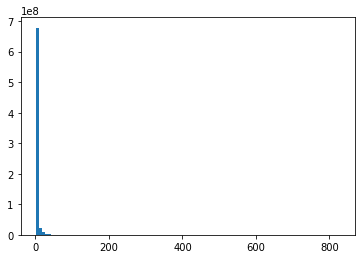

In [20]:
_ = plt.hist(counts, bins=100)

# SQL + Python hybrid

In [21]:
se.table("page_views").show(5)

+--------------+-----------+---------+--------+------------+--------------+
|          uuid|document_id|timestamp|platform|geo_location|traffic_source|
+--------------+-----------+---------+--------+------------+--------------+
|1fd5f051fba643|        120| 31905835|       1|          RS|             2|
|8557aa9004be3b|        120| 32053104|       1|       VN>44|             2|
|c351b277a358f0|        120| 54013023|       1|       KR>12|             1|
|8205775c5387f9|        120| 44196592|       1|       IN>16|             2|
|9cb0ccd8458371|        120| 65817371|       1|   US>CA>807|             2|
+--------------+-----------+---------+--------+------------+--------------+
only showing top 5 rows



In [22]:
df = se.sql(
"""
select 
    uuid, 
    collect_list(struct(document_id, timestamp, platform, geo_location, traffic_source)) as views
from page_views
group by uuid
""")
df.printSchema()

root
 |-- uuid: string (nullable = true)
 |-- views: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- document_id: string (nullable = true)
 |    |    |-- timestamp: string (nullable = true)
 |    |    |-- platform: string (nullable = true)
 |    |    |-- geo_location: string (nullable = true)
 |    |    |-- traffic_source: string (nullable = true)



In [23]:
%%time
! hdfs dfs -rm -r /platforms_per_user.pickle
from collections import defaultdict

def mapper(x):
    d = defaultdict(int)
    for row in x.views:
        d[row.platform] += 1
    return (x.uuid, d)

df.rdd.map(mapper).saveAsPickleFile("/platforms_per_user.pickle")

rm: `/platforms_per_user.pickle': No such file or directory
CPU times: user 41.7 ms, sys: 50.5 ms, total: 92.2 ms
Wall time: 5min 30s


# The same in Python (5x slower)

In [24]:
%%time
! hdfs dfs -rm -r /platforms_per_user2.pickle

def mapper(x):
    d = defaultdict(int)
    for row in x[1]:
        d[row.platform] += 1
    return (x[0], d)

(
    se
    .table("page_views")
    .rdd
    .groupBy(lambda x: x.uuid)
    .map(mapper)
    .saveAsPickleFile("/platforms_per_user2.pickle")
)

rm: `/platforms_per_user2.pickle': No such file or directory
CPU times: user 131 ms, sys: 80.7 ms, total: 211 ms
Wall time: 27min 3s


# Homework 1: Spark EDA

1. Find 10 most visited document_ids in page_views log

In [34]:
%%time
df = se.sql(
"""
select 
    document_id, 
    count(1) as cnt
from page_views
group by document_id
order by cnt desc
""")
df.write.parquet("/count_per_document.parquet", mode='overwrite')
se.read.parquet("/count_per_document.parquet").show(10)

+-----------+---+
|document_id|cnt|
+-----------+---+
|    1566859| 10|
|    1939908| 10|
|    1930619| 10|
|    1892524| 10|
|    1767730| 10|
|    2046812| 10|
|     331414| 10|
|     799060| 10|
|    2042828| 10|
|     710884| 10|
+-----------+---+
only showing top 10 rows

CPU times: user 3.34 ms, sys: 330 µs, total: 3.67 ms
Wall time: 16 s


2. Find 10 most visited topic_ids in page_views log (use documents_topics table)

In [26]:
%%time
df = se.sql(
"""
select 
    dt.topic_id, 
    count(1) as cnt
from page_views as pv
join documents_topics as dt on pv.document_id = dt.document_id
group by dt.topic_id
order by cnt desc
""")
df.write.parquet("/count_per_topic.parquet", mode='overwrite')
se.read.parquet("/count_per_topic.parquet").show(10)

+--------+---------+
|topic_id|      cnt|
+--------+---------+
|     216|109567943|
|     181| 98421838|
|     258| 78745609|
|     173| 71972872|
|     174| 60603792|
|     100| 54124532|
|     285| 52996876|
|     290| 50487421|
|     163| 48520134|
|     292| 46595834|
+--------+---------+
only showing top 10 rows

CPU times: user 1.73 ms, sys: 2.94 ms, total: 4.67 ms
Wall time: 32.1 s


3. Find out how many users have at least two different traffic_sources in their page_views log

In [27]:
%%time
df = se.sql(
"""
select count(distinct a.uuid) as user_count from (
select 
    uuid, 
    count(distinct traffic_source) as distinct_source_cnt
from page_views
group by uuid
having count(distinct traffic_source) > 1
) a
""")
df.write.parquet("/users_with_mult_traffic_sources.parquet", mode='overwrite')
se.read.parquet("/users_with_mult_traffic_sources.parquet").show(10)

+----------+
|user_count|
+----------+
|  93342305|
+----------+

CPU times: user 4.09 ms, sys: 618 µs, total: 4.7 ms
Wall time: 36.6 s


4. Find out the average uuid (user) CTR (number of clicks in all of her display_ids / (number of impressions ... + 10)). Plot the distribution of individual CTRs as a histogram (bins=100).

In [62]:
%%time
df = se.sql(
"""
with imps as (
    select uuid, count(1) as imps
    from page_views
    group by uuid
), clks as (

    select uuid, count(1) as clks
    from events
    group by uuid
)
select imps.uuid, coalesce(clks.clks, 0)/(imps.imps + 10) as CTR
from imps
left join clks on imps.uuid = clks.uuid
""")
df.write.parquet("/imps_clks_per_user.parquet", mode='overwrite')

CPU times: user 4.53 ms, sys: 0 ns, total: 4.53 ms
Wall time: 48.5 s


In [63]:
%%time
counts_ctr = se.read.parquet("/imps_clks_per_user.parquet").rdd\
    .map(lambda x: x.CTR)\
    .collect()

CPU times: user 29.9 s, sys: 9.78 s, total: 39.7 s
Wall time: 1min 32s


Average CTR: 0.0019602769004631003


(0.0, 0.2)

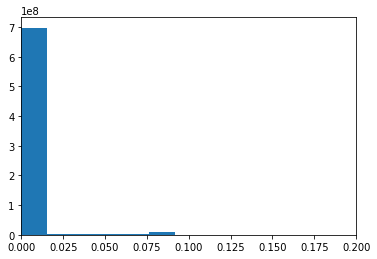

In [65]:
print(f'Average CTR: {np.mean(counts_ctr)}')
_ = plt.hist(counts_ctr, bins=100)
plt.xlim(0, 0.2)

5. Find out how many page views has an average user before encountering a display_id (use timestamp columns). Plot the distribution of individual values.

In [ ]:
%%time
df = se.sql(
"""
select  pv.uuid, 
        pv.timestamp, 
        case when e.display_id is null then 0 else 1 end as is_clk, 
        case when lag(e.display_id) over (partition by pv.uuid order by pv.timestamp) is null then 0 else 1 end as is_prev_clk
        
from    page_views as pv
left    join events e on e.document_id = pv.document_id

""")
df.write.parquet("/imps_clks_per_user.parquet", mode='overwrite')

In [53]:
tables = ["documents_topics", "events", "page_views",'count_per_document','count_per_topic',
          'users_with_mult_traffic_sources',]
for name in tqdm.tqdm(tables):
    df = se.read.parquet(f"/{name}.parquet")
    df.write.parquet(f"s3a://ydata-lsml/{name}.parquet")
    print(name)

AnalysisException: 'Path does not exist: hdfs://ip-172-31-13-168.us-east-2.compute.internal:8020/documents_topics.parquet;'